<a href="https://colab.research.google.com/github/AritraStark/Deeplense_GSOC_2022/blob/main/Deeplense_test_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Specific Test III. Learning Mass of Dark Matter Halo**

**Task:** Using the provided dataset implement a regression algorithm to learn the mapping between lensing images and the lensing dark matter halo mass. You can use the machine learning algorithm of your choice.  Please implement your approach in PyTorch or Keras and discuss your strategy.	

**Dataset:** [lens_data_alt.tgz](https://drive.google.com/file/d/1hu472ALwGPBcTCXSAM0VoCWmTktg9j-j/view)

**Dataset Description:** The data set consists of strong lensing images for cold dark matter with subhalo substructure. For each lensing image the corresponding fraction of mass in dark matter substructure is provided.

**Evaluation Metrics:** MSE (mean squared error)


Downloading the data and extracting: 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!tar --extract --file '/content/gdrive/MyDrive/lens_data_alt.tgz' 
print('Extraction done.')

Mounted at /content/gdrive
Extraction done.


Setting up imports

In [2]:
import os
import numpy as np
import tensorflow as tf
import cv2
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

Extracting from the dataset:

In [3]:
DATASET_PATH = './lens_data'
images = []
# f_sub -> mass fraction
f_subs = []
for f_name in os.listdir(DATASET_PATH):
  img, mass = np.load(os.path.join(DATASET_PATH,f_name),allow_pickle=True)
  # Add img and mass to separate lists
  # Add 1 as the first dimension for image
  images.append(img.reshape(1,img.shape[0],img.shape[1]))
  # Convert mass to a single element array with (1,1) dimensions
  f_subs.append(np.array(mass,ndmin=1))

# Images shape is (num_of_images,1,150,150)
images = np.stack(images).astype('float32')
# Mass fractions shape is (num_of_images,1)
f_subs = np.stack(f_subs).astype('float32')

Visualising the data:

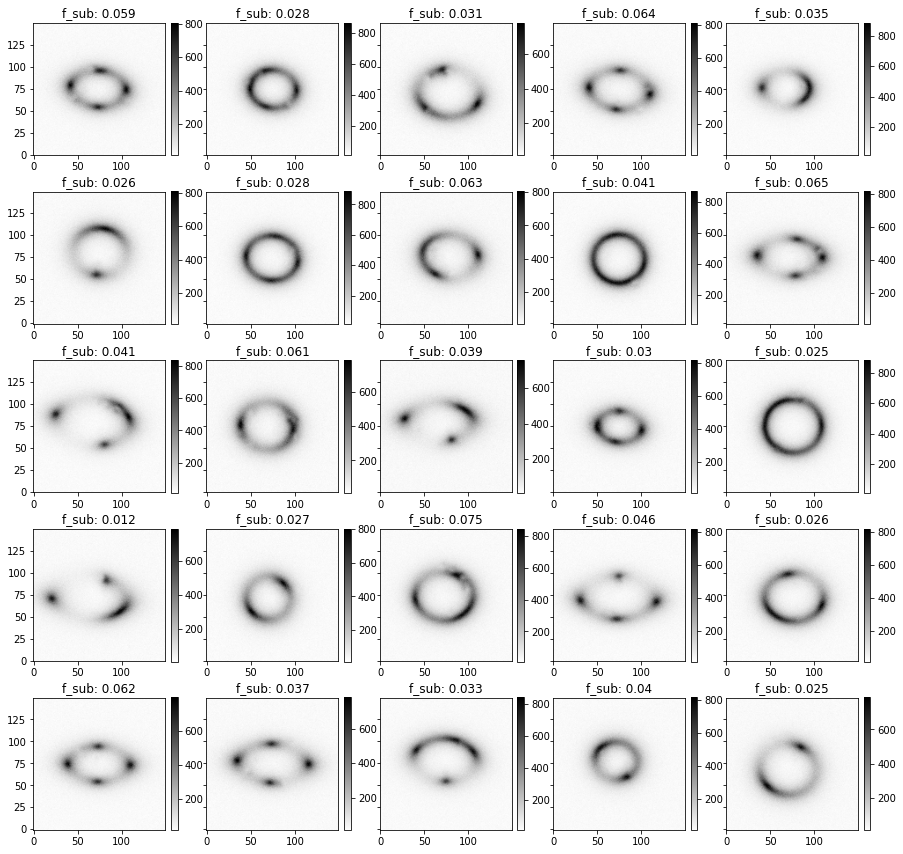

In [4]:
grid_size = (5,5)
figure,axis = plt.subplots(grid_size[0],grid_size[1],figsize=(15,15),sharey=True)
img_indx=0

for i in range(grid_size[0]):
  for j in range(grid_size[1]):
    # Plotting image
    img = axis[i][j].imshow(images[img_indx][0], cmap='binary', origin='lower')
    # Setting up a title
    axis[i][j].set_title(f'f_sub: {f_subs[img_indx][0]:.2}')
    # Plotting a colorbar to show the intensity of pixels
    plt.colorbar(img,ax=axis[i][j],fraction=0.046, pad=0.04)

    img_indx+=1
plt.show()

Setting up X and Y values: 

In [5]:
dataset = os.listdir('lens_data')
X_data = []
Y_data = []
j = 1
for i in dataset:
    data = np.load('lens_data/' + i, allow_pickle=True)
    img = data[0]
    img = img / 255.0
    img = cv2.resize(img, (64, 64))
    img = np.stack((img, img, img), axis=-1)
    X_data.append(img)
    Y_data.append(data[1])
    j += 1

X_data = np.array(X_data)
Y_data = np.array(Y_data)
X_data.shape, Y_data.shape

((20000, 64, 64, 3), (20000,))

Split the dataset into train and test:

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.1, random_state=42, shuffle=True)

Deleting variables to free up memory:

In [7]:
del X_data, Y_data

Defining the CNN model:

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['MSE'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 128)      

Training the model on training data and evaluating as well:

In [10]:
history = model.fit(
    X_train, 
    Y_train, 
    epochs=10, 
    validation_data=(X_test, Y_test)
)

Epoch 1/10
563/563 [==============================] - 21s 19ms/step - loss: 8.2793e-04 - MSE: 8.2793e-04 - val_loss: 2.2202e-04 - val_MSE: 2.2202e-04
Epoch 2/10
563/563 [==============================] - 10s 18ms/step - loss: 2.1765e-04 - MSE: 2.1765e-04 - val_loss: 2.1729e-04 - val_MSE: 2.1729e-04
Epoch 3/10
563/563 [==============================] - 10s 18ms/step - loss: 2.1753e-04 - MSE: 2.1753e-04 - val_loss: 2.1677e-04 - val_MSE: 2.1677e-04
Epoch 4/10
563/563 [==============================] - 10s 18ms/step - loss: 2.1751e-04 - MSE: 2.1751e-04 - val_loss: 2.1437e-04 - val_MSE: 2.1437e-04
Epoch 5/10
563/563 [==============================] - 10s 18ms/step - loss: 2.1691e-04 - MSE: 2.1691e-04 - val_loss: 2.0714e-04 - val_MSE: 2.0714e-04
Epoch 6/10
563/563 [==============================] - 10s 18ms/step - loss: 2.1829e-04 - MSE: 2.1829e-04 - val_loss: 2.1114e-04 - val_MSE: 2.1114e-04
Epoch 7/10
563/563 [==============================] - 10s 18ms/step - loss: 2.1747e-04 - MSE: 2.1747

Calculating MSE:

In [11]:
mse = model.evaluate(X_test, Y_test)

63/63 [==============================] - 1s 9ms/step - loss: 2.0535e-04 - MSE: 2.0535e-04


Plotting the MSE graph:

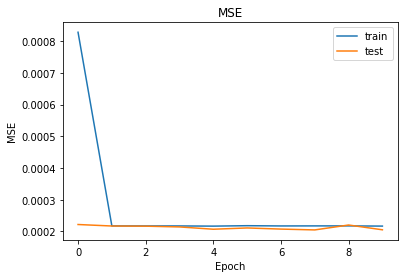

In [12]:
plt.figure()
plt.title('MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()